https://python.langchain.com/v0.2/docs/tutorials/sql_qa/

In [1]:
#building a QA system over SQL data

it is common to generate text that can be searched against a vector database, the approach for structured data is often for the LLM to write and execute queries in a DSL, such as SQL.

1. model-generated SQL query models might have security concerns , you need to limit the permissions and not delete the data

a. Data corruption or loss.

b. Unauthorized access to confidential information.

c. Compromised performance or availability of critical resources.

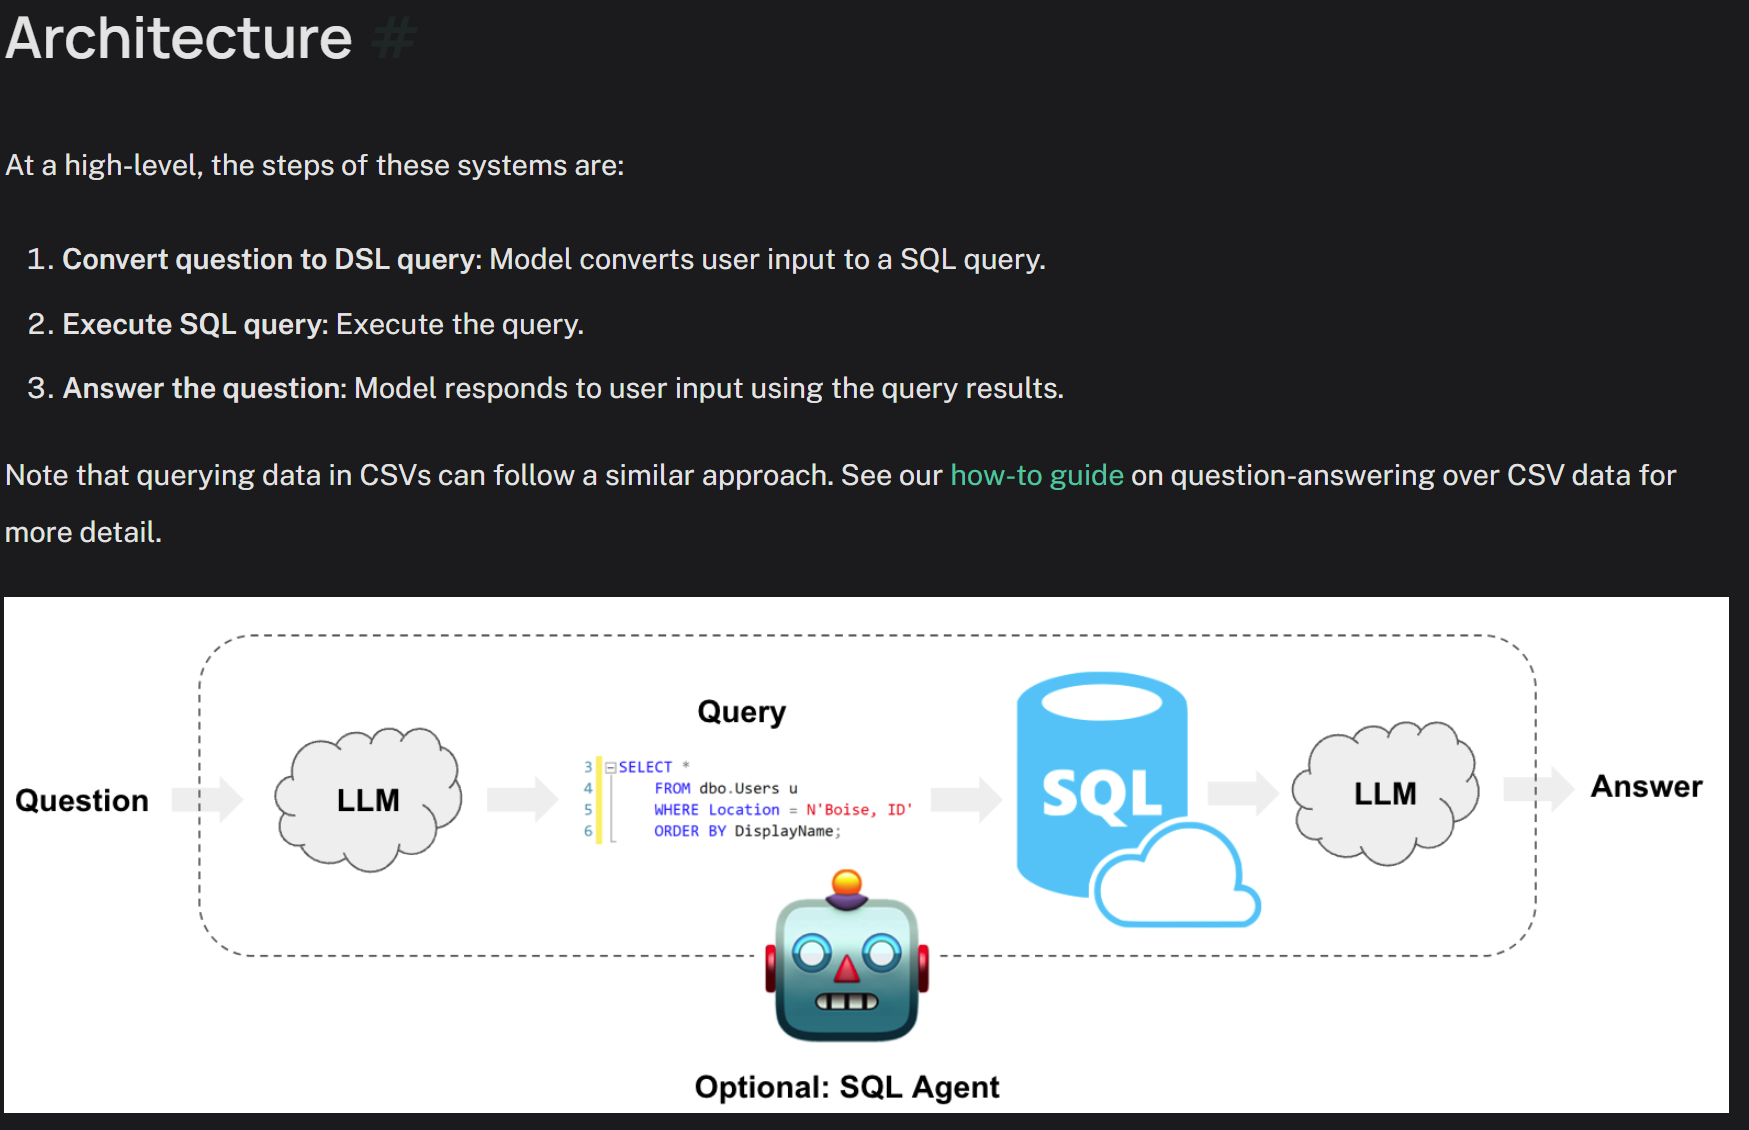

### Setup

In [2]:
from dotenv import load_dotenv
import os
load_dotenv()
os.environ["LANGCHAIN_TRACING_V2"] = "true"

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = "gpt-3.5-turbo")

: 

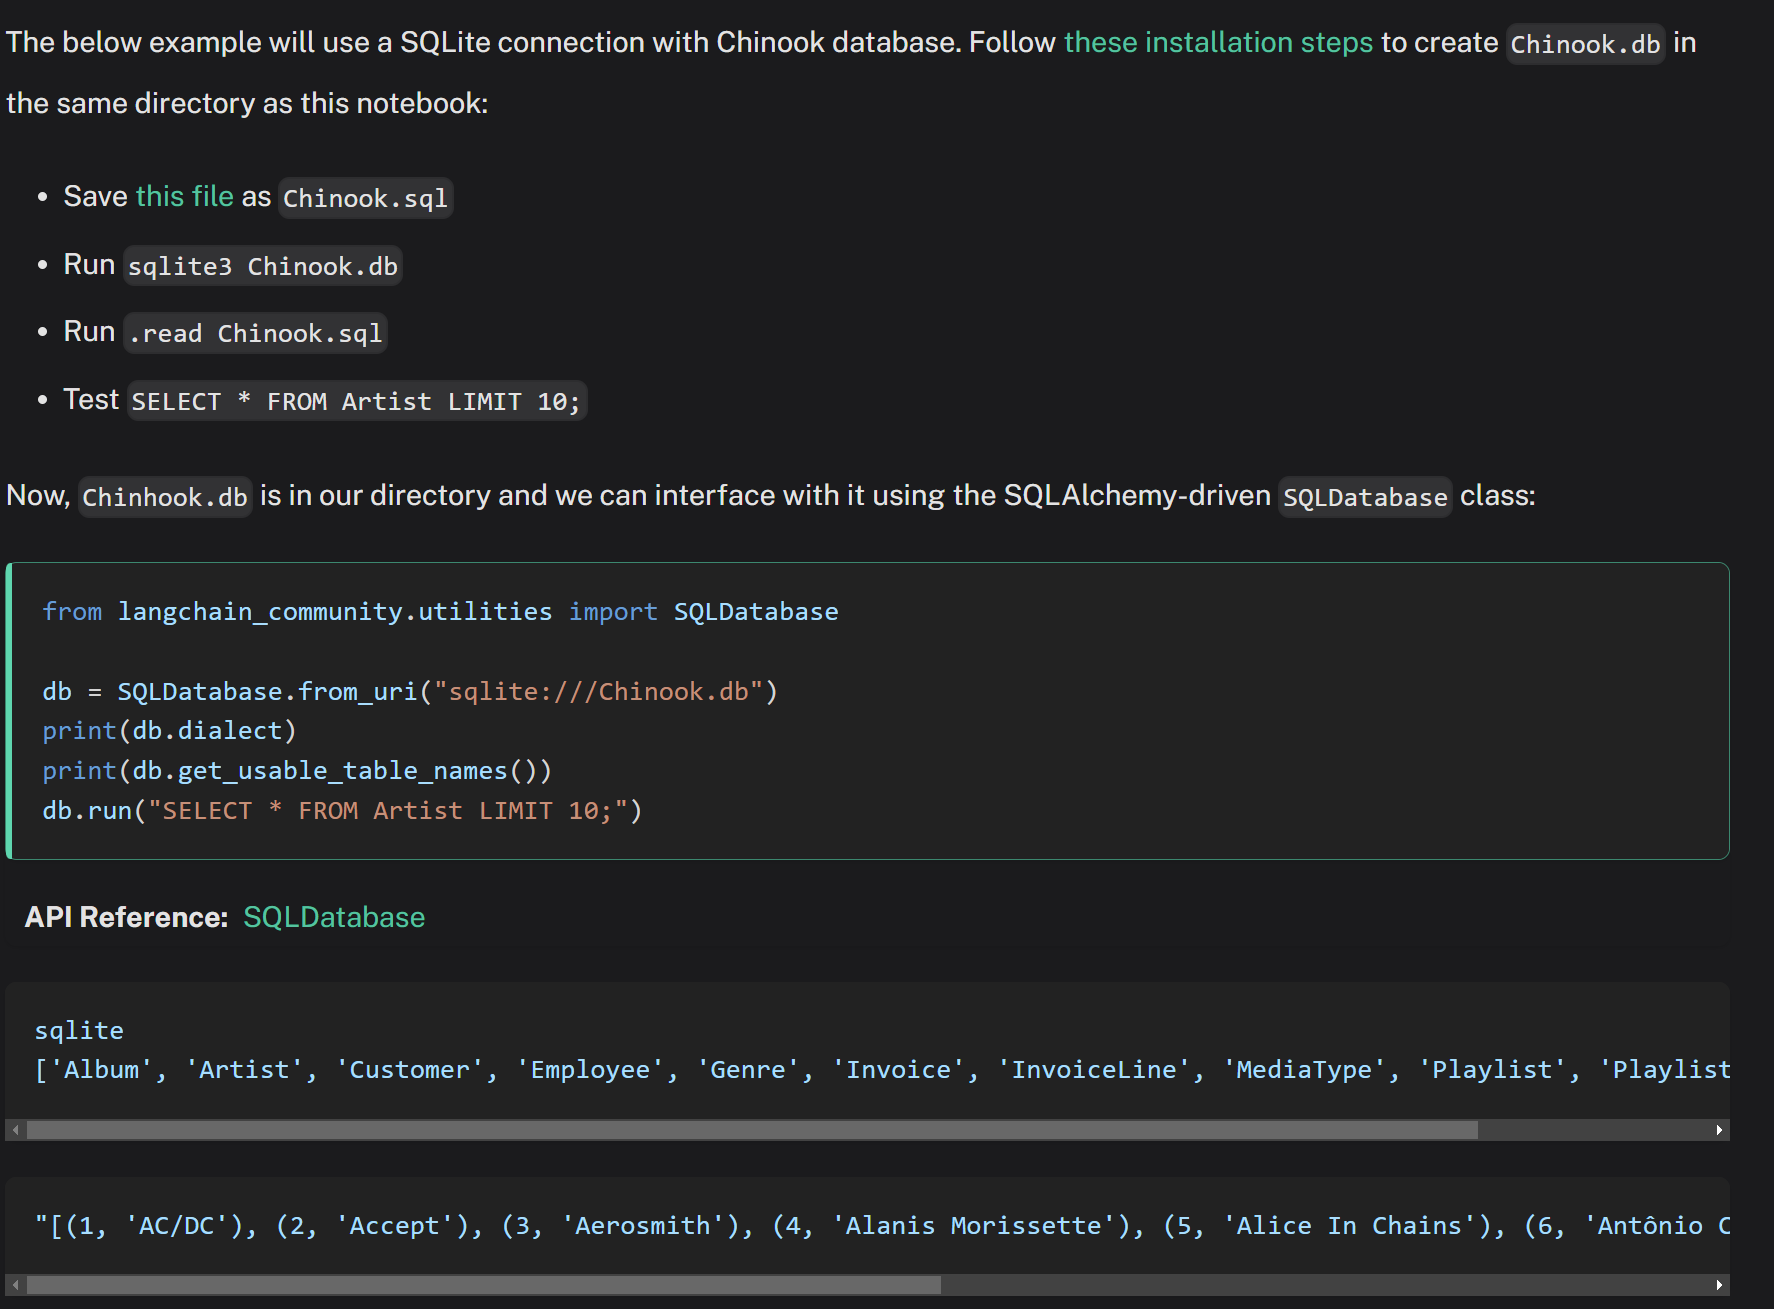

1. convert the question into a SQL query;
2. execute the query;
3. use the result to answer the original question.

There are scenarios not supported by this arrangement. For example, this system will execute a SQL query for any user input-- even "hello". Importantly, as we'll see below, some questions require more than one query to answer. We will address these scenarios in the Agents section.

In [ ]:
from langchain.chains import create_sql_query_chain

chain = create_sql_query_chain(llm, db)
response = chain.invoke({"question": "How many employees are there"})
response

In [ ]:
db.run(response)



https://smith.langchain.com/public/c8fa52ea-be46-4829-bde2-52894970b830/r

Kindly check the main link to move forwards 

In [ ]:
# Query execution 
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

execute_query = QuerySQLDataBaseTool(db=db)
write_query = create_sql_query_chain(llm, db)
chain = write_query | execute_query
chain.invoke({"question": "How many employees are there"})

In [ ]:
# Answering the Question

from operator import itemgetter

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough

answer_prompt = PromptTemplate.from_template(
    """Given the following user question, corresponding SQL query, and SQL result, answer the user question.

Question: {question}
SQL Query: {query}
SQL Result: {result}
Answer: """
)

chain = (
    RunnablePassthrough.assign(query=write_query).assign(
        result=itemgetter("query") | execute_query
    )
    | answer_prompt
    | llm
    | StrOutputParser()
)

chain.invoke({"question": "How many employees are there"})

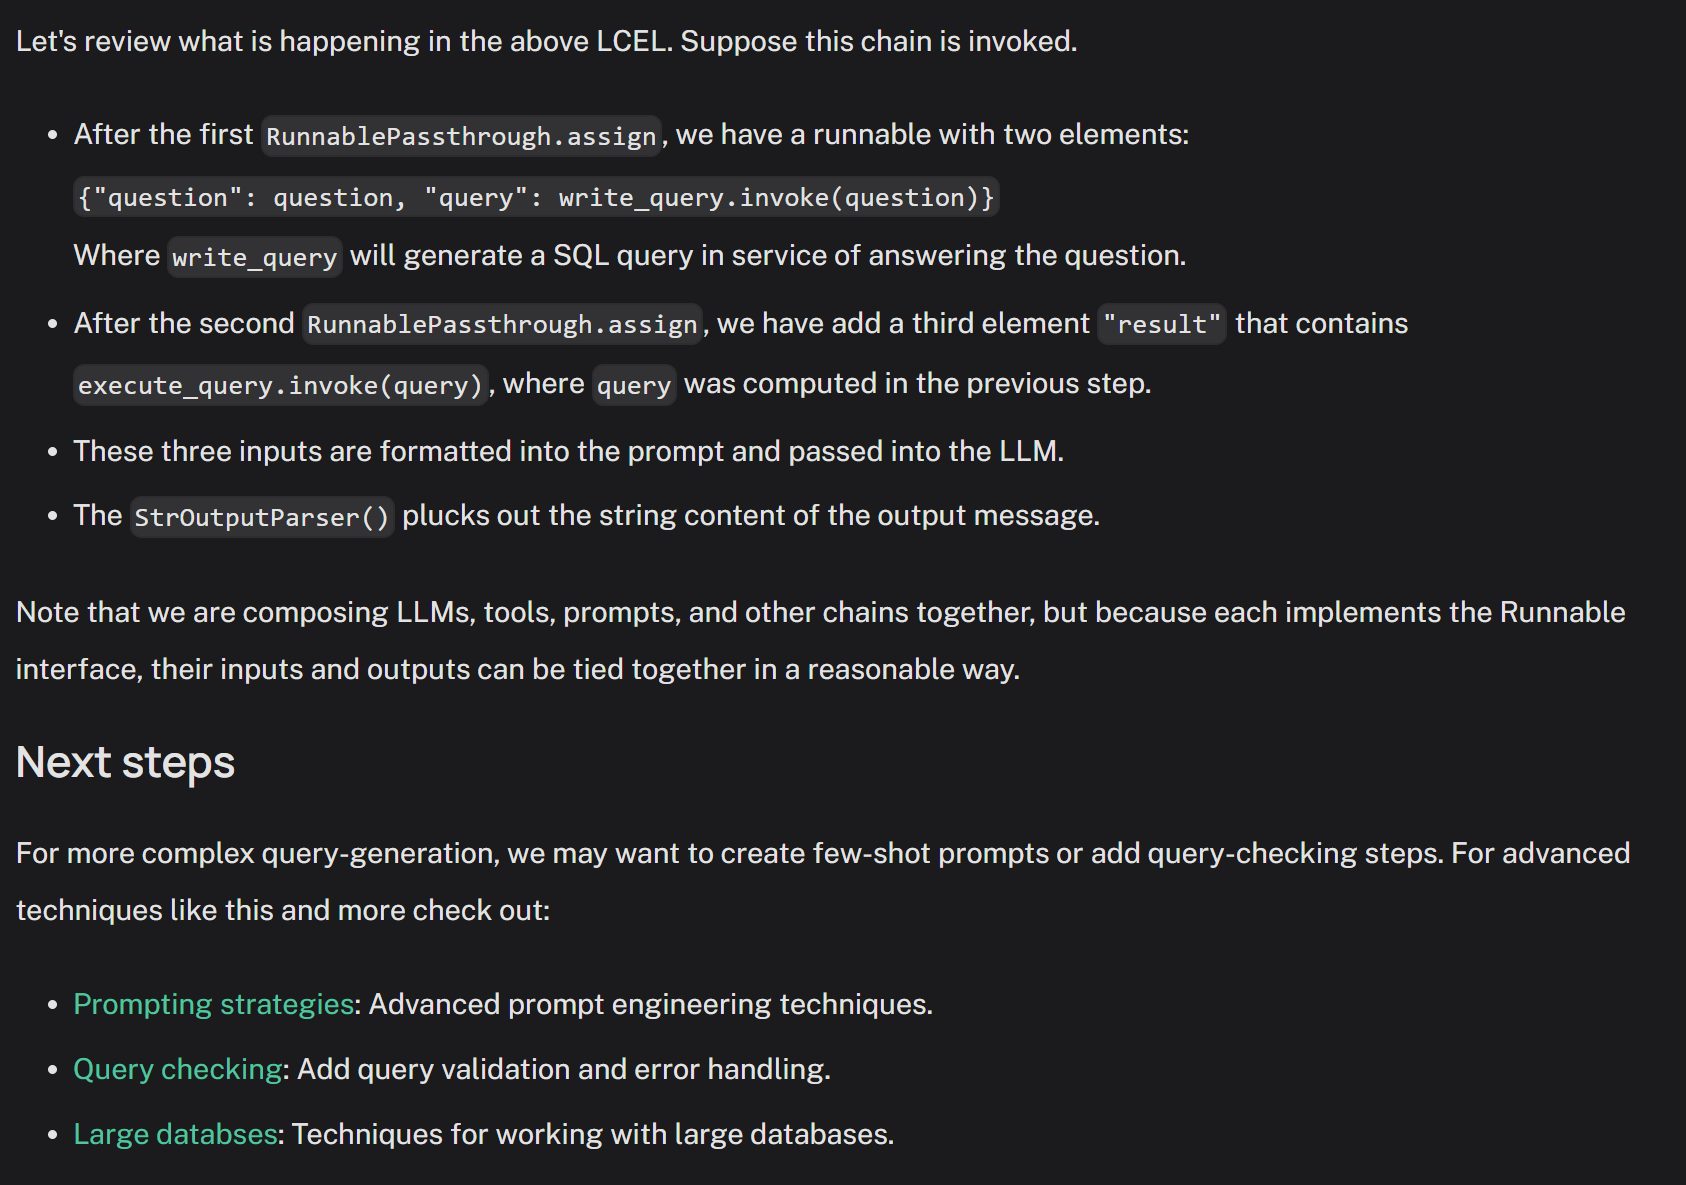

### Agents

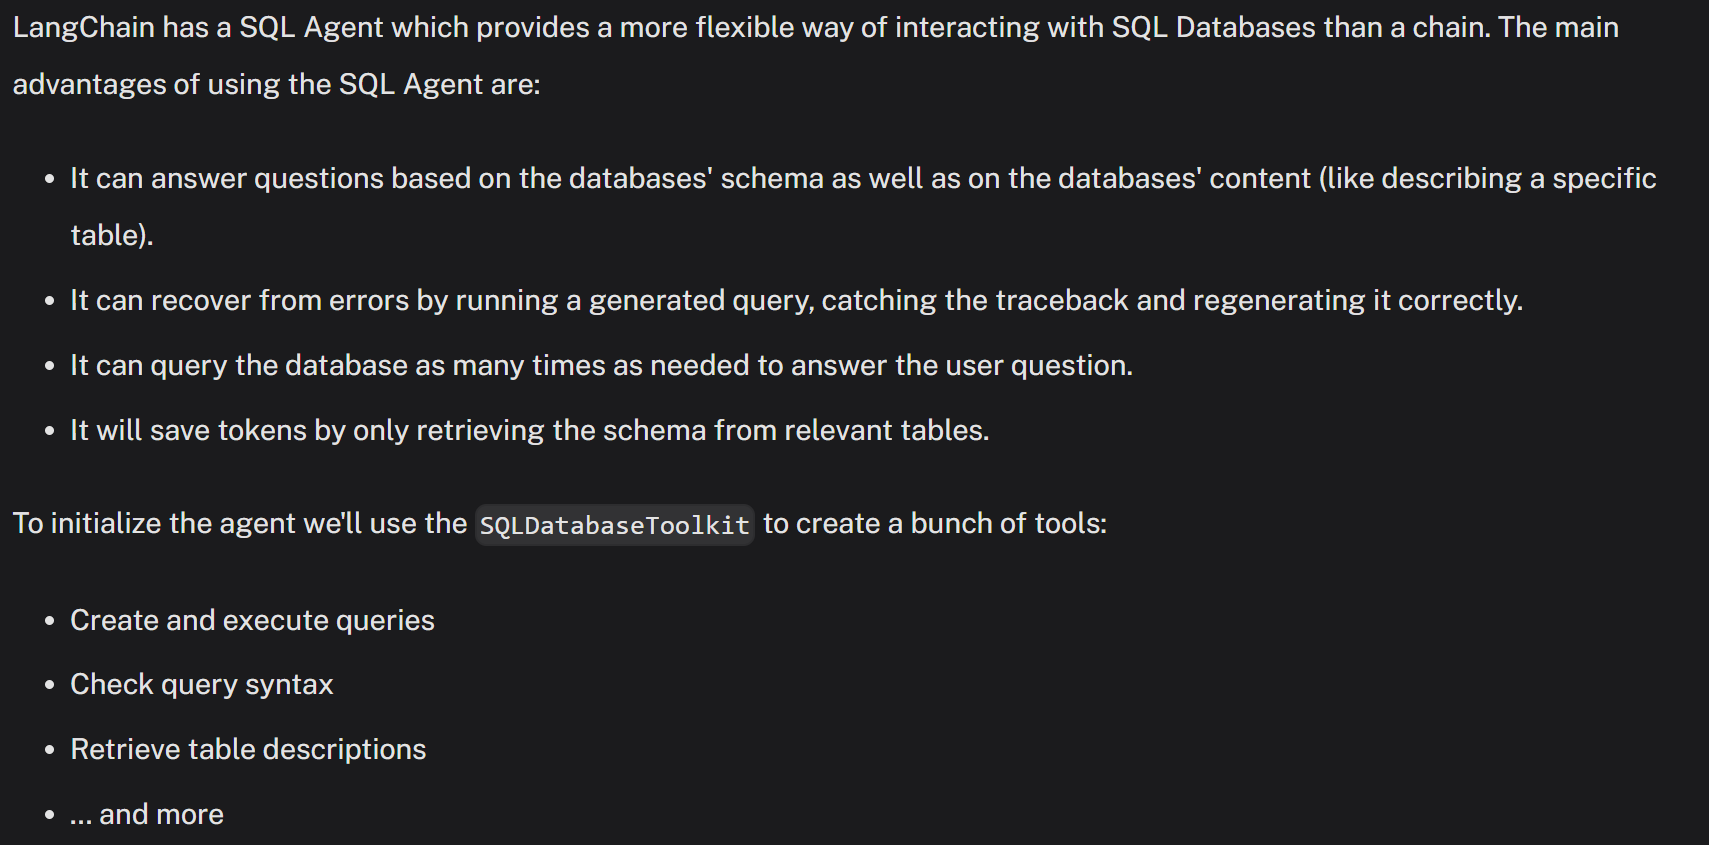

In [ ]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()
tools

[QuerySQLDataBaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x113403b50>),
 
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x113403b50>),
 
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x113403b50>),
 
 QuerySQLCheckerTool(description='Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x113403b50>, 
 
 llm=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x115b7e890>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x115457e10>, temperature=0.0, openai_api_key=SecretStr('**********'), openai_proxy=''), llm_chain=LLMChain(prompt=PromptTemplate(input_variables=['dialect', 'query'], template='\n{query}\nDouble check the {dialect} query above for common mistakes, including:\n- Using NOT IN with NULL values\n- Using UNION when UNION ALL should have been used\n- Using BETWEEN for exclusive ranges\n- Data type mismatch in predicates\n- Properly quoting identifiers\n- Using the correct number of arguments for functions\n- Casting to the correct data type\n- Using the proper columns for joins\n\nIf there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.\n\nOutput the final SQL query only.\n\nSQL Query: '), llm=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x115b7e890>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x115457e10>, temperature=0.0, openai_api_key=SecretStr('**********'), openai_proxy='')))]

In [ ]:
# system prompt
from langchain_core.messages import SystemMessage

SQL_PREFIX = """You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see what you can query.
Do NOT skip this step.
Then you should query the schema of the most relevant tables."""

system_message = SystemMessage(content=SQL_PREFIX)

In [ ]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools, messages_modifier=system_message)

for s in agent_executor.stream(
    {"messages": [HumanMessage(content="Which country's customers spent the most?")]}
):
    print(s)
    print("----")

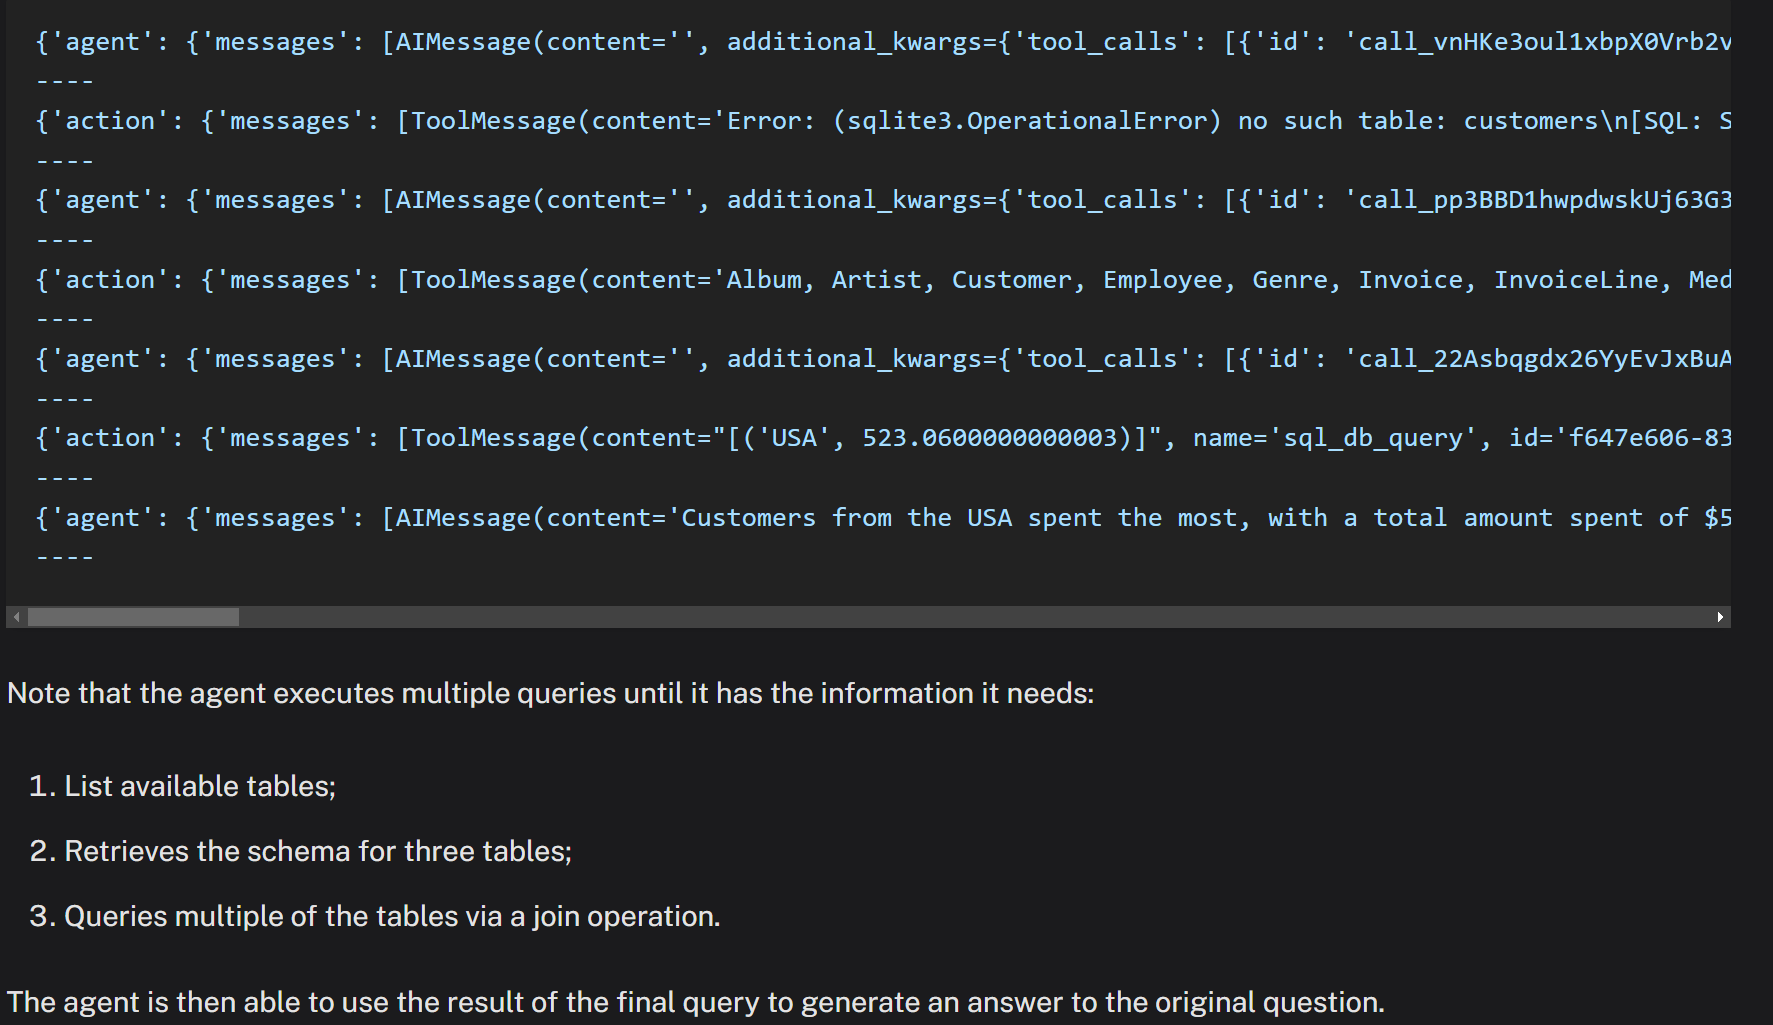

In [ ]:
for s in agent_executor.stream(
    {"messages": [HumanMessage(content="Describe the playlisttrack table")]}
):
    print(s)
    print("----")

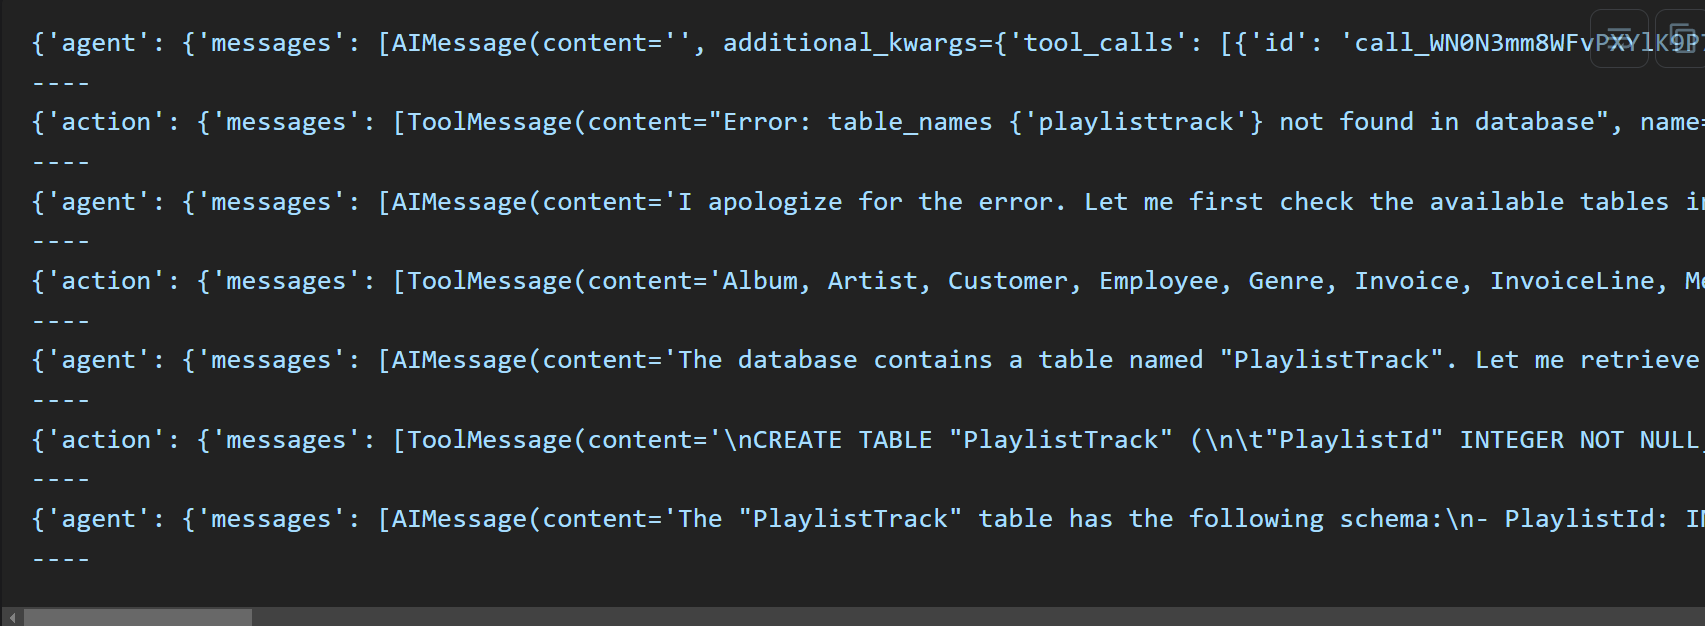

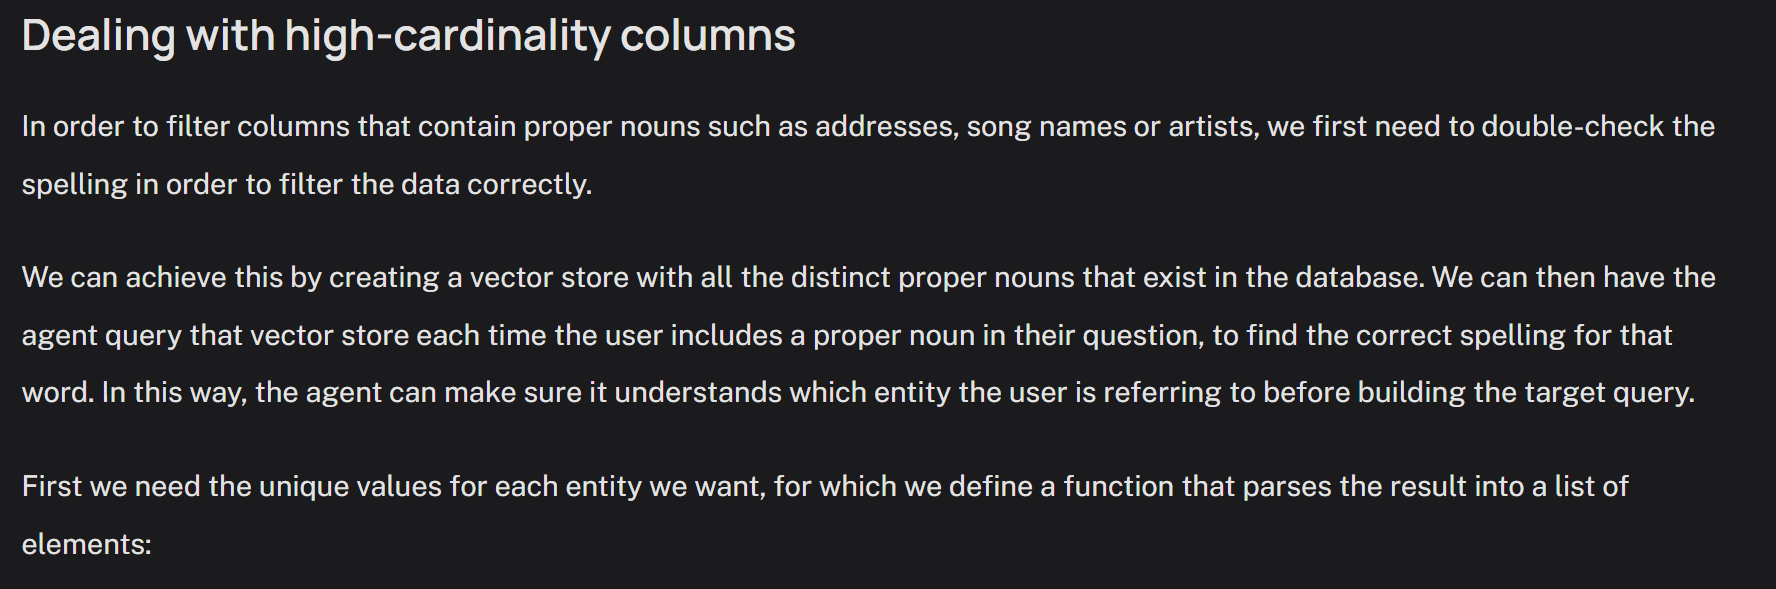

In [ ]:
import ast
import re


def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))


artists = query_as_list(db, "SELECT Name FROM Artist")
albums = query_as_list(db, "SELECT Title FROM Album")
albums[:5]

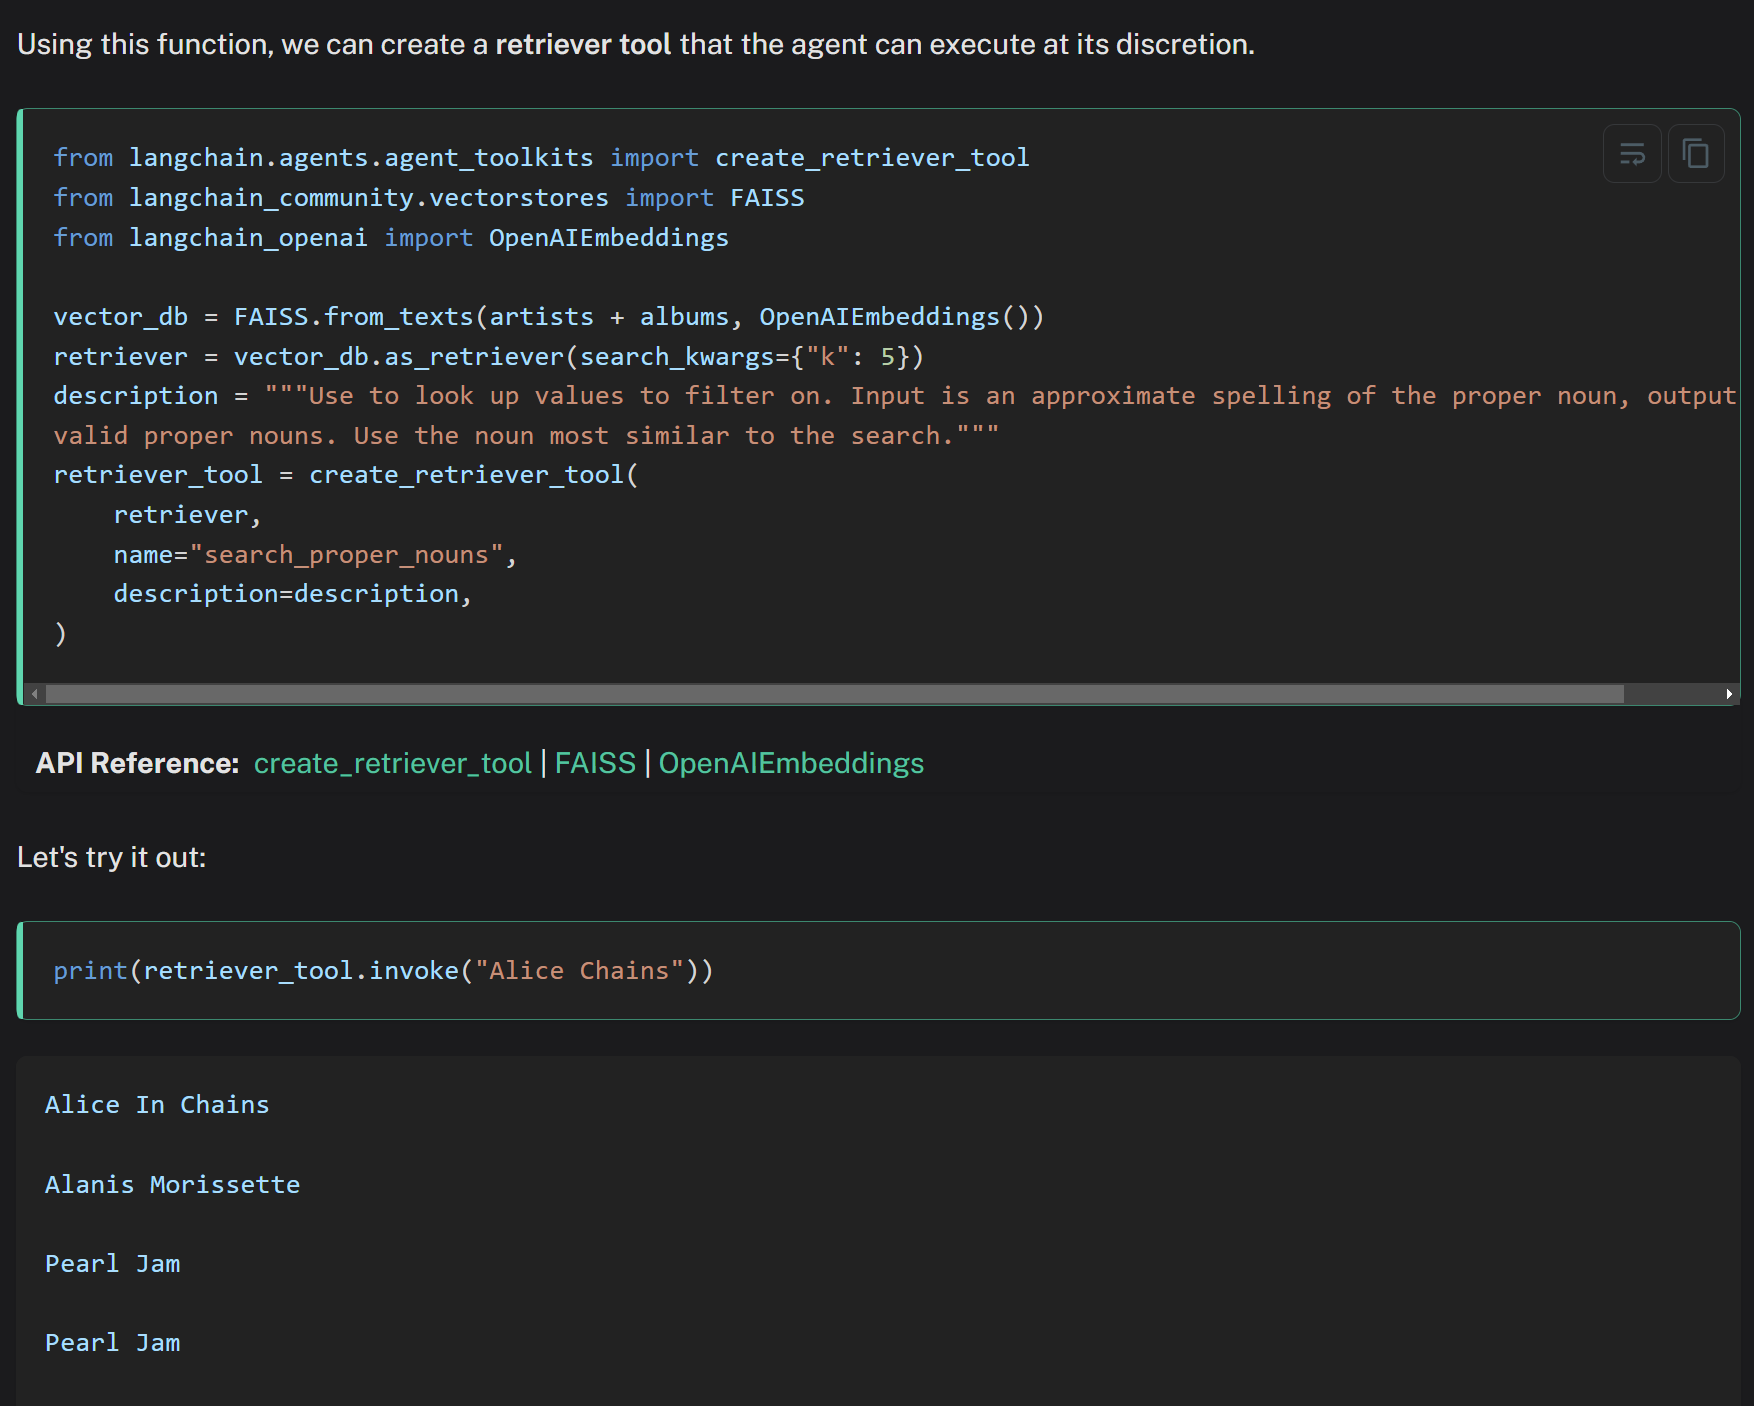

In [ ]:
# all together
system = """You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the given tools. Only use the information returned by the tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

You have access to the following tables: {table_names}

If you need to filter on a proper noun, you must ALWAYS first look up the filter value using the "search_proper_nouns" tool!
Do not try to guess at the proper name - use this function to find similar ones.""".format(
    table_names=db.get_usable_table_names()
)

system_message = SystemMessage(content=system)

tools.append(retriever_tool)

agent = create_react_agent(llm, tools, messages_modifier=system_message)

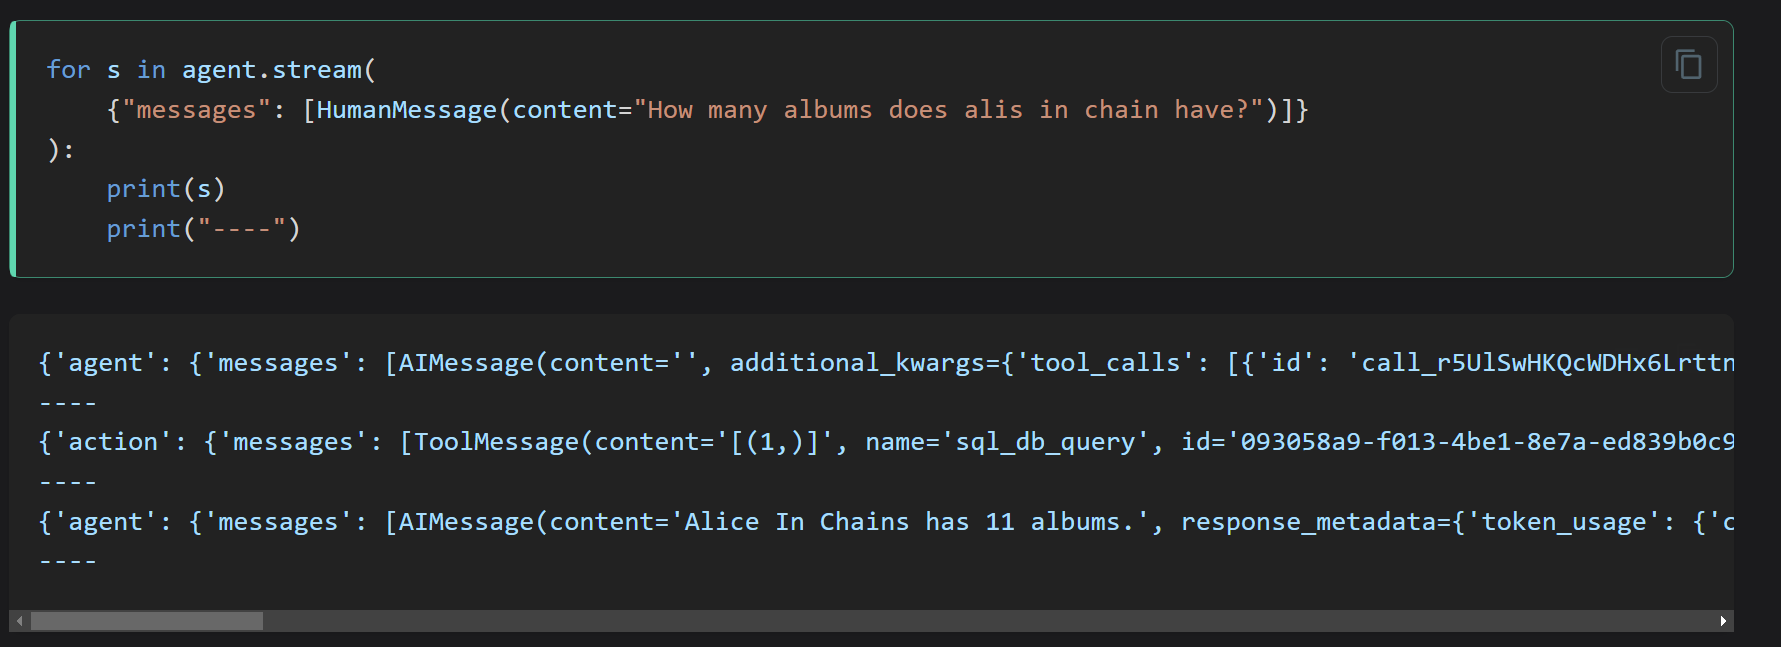